In [214]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.utils.data
from sklearn.model_selection import KFold

In [223]:
# load all data
data = pd.read_csv('SFEW.csv',  header=None, skiprows=1)

# drop first column
data.drop(data.columns[0], axis=1, inplace=True)
data.drop([205], axis=0, inplace=True) #drop the row with no PHOG descriptors

# try shuffle data
data = data.sample(frac=1).reset_index(drop=True)

#preprocessing????
for column in data:
    if column == 1:
        pass
    else:
        data[column] = data.loc[:, [column]].apply(lambda x: (x - x.mean()) / x.std())

#reorder
data = data[[2,3,4,5,6,7,8,9,10,11,1]]
        
# randomly split data into training set (80%) and testing set (20%)
msk = np.random.rand(len(data)) < 0.8
train_data = data[msk]
test_data = data[~msk]

train_LPQ = train_data.drop([7,8,9,10,11], axis=1)
train_PHOG = train_data.drop([2,3,4,5,6], axis=1)

test_LPQ = test_data.drop([7,8,9,10,11], axis=1)
test_PHOG = test_data.drop([2,3,4,5,6], axis=1)

train_LPQ_loader = torch.utils.data.DataLoader(train_LPQ, batch_size=32, shuffle=True)
test_LPQ_loader = torch.utils.data.DataLoader(test_LPQ, batch_size=32, shuffle=True)
train_PHOG_loader = torch.utils.data.DataLoader(train_PHOG, batch_size=32, shuffle=True)
test_PHOG_loader = torch.utils.data.DataLoader(test_PHOG, batch_size=32, shuffle=True)

1     3.000000
2    -0.000814
3     0.032472
4    -0.003461
5    -0.007609
6     0.004402
7     0.006187
8    -0.004140
9    -0.007445
10    0.005450
11    0.002019
Name: 204, dtype: float64


In [189]:
train_LPQ_x = torch.Tensor(train_data.iloc[:, 0:5].values)
train_PHOG_x = torch.Tensor(train_data.iloc[:, 5:10].values)
train_y = torch.Tensor(train_data.iloc[:, 10].values-1).long()

train_LPQ_dataset = torch.utils.data.TensorDataset(train_LPQ_x, train_y)
train_PHOG_dataset = torch.utils.data.TensorDataset(train_PHOG_x, train_y)

train_LPQ_loader = torch.utils.data.DataLoader(train_LPQ_dataset, batch_size=32, shuffle=True)
train_PHOG_loader = torch.utils.data.DataLoader(train_PHOG_dataset, batch_size=32, shuffle=True)

test_LPQ_x = torch.Tensor(test_data.iloc[:, 0:5].values)
test_PHOG_x = torch.Tensor(test_data.iloc[:, 5:10].values)
test_y = torch.Tensor(test_data.iloc[:, 10].values-1).long()

In [209]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(5, hidden_size)
        self.sigmoid = nn.Sigmoid()
        self.out = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.sigmoid(out)
        out = self.out(out)
        return out

net = Net(5, 100, 7)

In [210]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.1)

In [206]:
# define a function to plot confusion matrix
def plot_confusion(input_sample, num_classes, des_output, actual_output):
    confusion = torch.zeros(num_classes, num_classes)
    for i in range(input_sample):
        actual_class = actual_output[i]
        predicted_class = des_output[i]

        confusion[actual_class][predicted_class] += 1

    return confusion

Epoch [1/301], Loss: 53.2580, Accuracy: 14.37 %
Epoch [51/301], Loss: 25.0841, Accuracy: 44.23 %
Epoch [101/301], Loss: 22.6519, Accuracy: 48.77 %
Epoch [151/301], Loss: 19.3032, Accuracy: 55.01 %
Epoch [201/301], Loss: 18.2467, Accuracy: 58.79 %
Epoch [251/301], Loss: 19.0101, Accuracy: 58.98 %
Epoch [301/301], Loss: 15.6888, Accuracy: 63.52 %


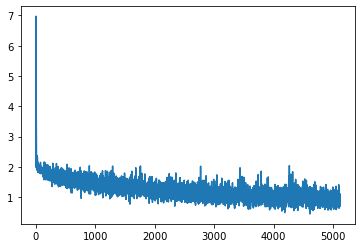

Confusion matrix for training:
tensor([[56.,  0.,  4.,  6.,  3.,  3.,  1.],
        [ 3., 27.,  4.,  2.,  7.,  4.,  5.],
        [ 2.,  1., 64.,  1.,  6.,  2.,  3.],
        [ 3.,  1.,  7., 57.,  7.,  4.,  1.],
        [ 2.,  0.,  9.,  7., 59.,  1.,  6.],
        [ 5.,  3.,  7.,  5.,  6., 48.,  2.],
        [ 4.,  3., 11.,  1., 15.,  6., 45.]])
Testing Accuracy: 26.03 %
Confusion matrix for testing:
tensor([[ 6.,  2.,  7.,  2.,  4.,  2.,  4.],
        [ 4.,  2.,  6.,  2.,  3.,  5.,  1.],
        [ 3.,  0., 10.,  1.,  5.,  1.,  1.],
        [ 1.,  0.,  4.,  8.,  3.,  2.,  2.],
        [ 0.,  1.,  2.,  3.,  6.,  3.,  1.],
        [ 3.,  1.,  5.,  3.,  7.,  4.,  1.],
        [ 2.,  0.,  7.,  1.,  0.,  3.,  2.]])


In [207]:
all_losses = []
num_epochs = 301

# train the model by batch
for epoch in range(num_epochs):
    total = 0
    correct = 0
    total_loss = 0
    for step, (batch_x, batch_y) in enumerate(train_LPQ_loader):
        X = batch_x
        Y = batch_y.long()

        # Forward + Backward + Optimize
        optimizer.zero_grad()  # zero the gradient buffer
        outputs = net(X)
        loss = criterion(outputs, Y)
        all_losses.append(loss.item())
        loss.backward()
        optimizer.step()

        if (epoch % 50 == 0):
            _, predicted = torch.max(outputs, 1)
            # calculate and print accuracy
            total = total + predicted.size(0)
            correct = correct + sum(predicted.data.numpy() == Y.data.numpy())
            total_loss = total_loss + loss
    if (epoch % 50 == 0):
        print('Epoch [%d/%d], Loss: %.4f, Accuracy: %.2f %%'
              % (epoch + 1, num_epochs,
                 total_loss, 100 * correct/total))

import matplotlib.pyplot as plt
#
plt.figure()
plt.plot(all_losses)
plt.show()

outputs = net(train_LPQ_x)
_, predicted = torch.max(outputs, 1)

print('Confusion matrix for training:')
print(plot_confusion(train_LPQ_x.shape[0], 7, predicted.long().data, train_y.data))

#LPQ testing
outputs = net(test_LPQ_x)
_, predicted = torch.max(outputs, 1)

total = predicted.size(0)
correct = predicted.data.numpy() == test_y.data.numpy()

print('Testing Accuracy: %.2f %%' % (100 * sum(correct)/total))

print('Confusion matrix for testing:')
print(plot_confusion(test_LPQ_x.shape[0], 7, predicted.long().data, test_y.data))

Epoch [1/301], Loss: nan, Accuracy: 16.07 %
Epoch [51/301], Loss: nan, Accuracy: 13.80 %
Epoch [101/301], Loss: nan, Accuracy: 13.80 %
Epoch [151/301], Loss: nan, Accuracy: 13.80 %
Epoch [201/301], Loss: nan, Accuracy: 13.80 %
Epoch [251/301], Loss: nan, Accuracy: 13.80 %
Epoch [301/301], Loss: nan, Accuracy: 13.80 %


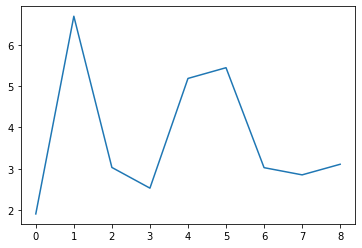

Confusion matrix for training:
tensor([[73.,  0.,  0.,  0.,  0.,  0.,  0.],
        [52.,  0.,  0.,  0.,  0.,  0.,  0.],
        [79.,  0.,  0.,  0.,  0.,  0.,  0.],
        [80.,  0.,  0.,  0.,  0.,  0.,  0.],
        [84.,  0.,  0.,  0.,  0.,  0.,  0.],
        [76.,  0.,  0.,  0.,  0.,  0.,  0.],
        [85.,  0.,  0.,  0.,  0.,  0.,  0.]])
Testing Accuracy: 18.49 %
Confusion matrix for testing:
tensor([[27.,  0.,  0.,  0.,  0.,  0.,  0.],
        [23.,  0.,  0.,  0.,  0.,  0.,  0.],
        [21.,  0.,  0.,  0.,  0.,  0.,  0.],
        [20.,  0.,  0.,  0.,  0.,  0.,  0.],
        [16.,  0.,  0.,  0.,  0.,  0.,  0.],
        [24.,  0.,  0.,  0.,  0.,  0.,  0.],
        [15.,  0.,  0.,  0.,  0.,  0.,  0.]])


In [211]:
all_losses = []

# train the model by batch
for epoch in range(num_epochs):
    total = 0
    correct = 0
    total_loss = 0
    for step, (batch_x, batch_y) in enumerate(train_PHOG_loader):
        X = batch_x
        Y = batch_y.long()

        # Forward + Backward + Optimize
        optimizer.zero_grad()  # zero the gradient buffer
        outputs = net(X)
        loss = criterion(outputs, Y)
        all_losses.append(loss.item())
        loss.backward()
        optimizer.step()

        if (epoch % 50 == 0):
            _, predicted = torch.max(outputs, 1)
            # calculate and print accuracy
            total = total + predicted.size(0)
            correct = correct + sum(predicted.data.numpy() == Y.data.numpy())
            total_loss = total_loss + loss
    if (epoch % 50 == 0):
        print('Epoch [%d/%d], Loss: %.4f, Accuracy: %.2f %%'
              % (epoch + 1, num_epochs,
                 total_loss, 100 * correct/total))

import matplotlib.pyplot as plt
#
plt.figure()
plt.plot(all_losses)
plt.show()

outputs = net(train_PHOG_x)
_, predicted = torch.max(outputs, 1)

print('Confusion matrix for training:')
print(plot_confusion(train_PHOG_x.shape[0], 7, predicted.long().data, train_y.data))

#PHOG testing
outputs = net(test_PHOG_x)
_, predicted = torch.max(outputs, 1)

total = predicted.size(0)
correct = predicted.data.numpy() == test_y.data.numpy()

print('Testing Accuracy: %.2f %%' % (100 * sum(correct)/total))

print('Confusion matrix for testing:')
print(plot_confusion(test_PHOG_x.shape[0], 7, predicted.long().data, test_y.data))

In [179]:
train_combo_x = torch.Tensor(train_data.iloc[:, 0:10].values)
train_y = torch.Tensor(train_data.iloc[:, 10].values-1).long()

train_combo_dataset = torch.utils.data.TensorDataset(train_combo_x, train_y)

train_combo_loader = torch.utils.data.DataLoader(train_combo_dataset, batch_size=32, shuffle=True)

test_combo_x = torch.Tensor(test_data.iloc[:, 0:10].values)
test_y = torch.Tensor(test_data.iloc[:, 10].values-1).long()

In [183]:
class Net_combo(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net_combo, self).__init__()
        self.fc1 = nn.Linear(5, hidden_size)
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.sigmoid(out)
        out = self.fc2(out)
        return out

net_combo = Net_combo(10, 50, 7)

In [186]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net_combo.parameters(), lr=0.1)

Epoch [1/301], Loss: 15.4208, Accuracy: 61.57 %
Epoch [51/301], Loss: 15.4298, Accuracy: 61.57 %
Epoch [101/301], Loss: 15.4077, Accuracy: 61.57 %
Epoch [151/301], Loss: 15.4284, Accuracy: 61.57 %
Epoch [201/301], Loss: 15.4101, Accuracy: 61.57 %
Epoch [251/301], Loss: 15.4384, Accuracy: 61.57 %
Epoch [301/301], Loss: 15.4249, Accuracy: 61.57 %


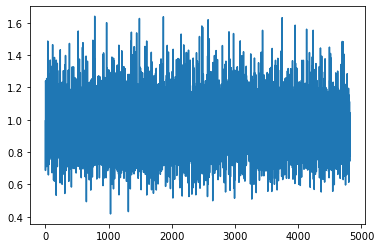

Confusion matrix for training:
tensor([[52.,  3.,  6., 14.,  2.,  2.,  3.],
        [ 2., 35.,  1.,  8.,  1.,  4.,  5.],
        [ 4.,  0., 52.,  8.,  3.,  2.,  1.],
        [ 2.,  2.,  1., 59.,  0.,  5.,  2.],
        [ 4.,  8.,  6., 12., 30.,  6.,  7.],
        [ 3.,  5.,  5., 16.,  4., 49.,  1.],
        [ 4., 13.,  4.,  8.,  6.,  3., 37.]])
Testing Accuracy: 20.00 %
Confusion matrix for testing:
tensor([[ 4.,  2.,  3.,  2.,  2.,  3.,  2.],
        [ 4.,  3.,  3.,  3.,  2.,  3.,  1.],
        [ 5.,  5.,  8.,  4.,  3.,  2.,  3.],
        [ 4.,  3.,  2., 10.,  3.,  3.,  4.],
        [ 6.,  5.,  2.,  4.,  3.,  2.,  5.],
        [ 2.,  5.,  2.,  4.,  1.,  2.,  1.],
        [ 4.,  5.,  3.,  5.,  1.,  4.,  3.]])


In [187]:
all_losses = []
num_epochs = 301

# train the model by batch
for epoch in range(num_epochs):
    total = 0
    correct = 0
    total_loss = 0
    for step, (batch_x, batch_y) in enumerate(train_LPQ_loader):
        X = batch_x
        Y = batch_y.long()

        # Forward + Backward + Optimize
        optimizer.zero_grad()  # zero the gradient buffer
        outputs = net(X)
        loss = criterion(outputs, Y)
        all_losses.append(loss.item())
        loss.backward()
        optimizer.step()

        if (epoch % 50 == 0):
            _, predicted = torch.max(outputs, 1)
            # calculate and print accuracy
            total = total + predicted.size(0)
            correct = correct + sum(predicted.data.numpy() == Y.data.numpy())
            total_loss = total_loss + loss
    if (epoch % 50 == 0):
        print('Epoch [%d/%d], Loss: %.4f, Accuracy: %.2f %%'
              % (epoch + 1, num_epochs,
                 total_loss, 100 * correct/total))

import matplotlib.pyplot as plt
#
plt.figure()
plt.plot(all_losses)
plt.show()

outputs = net(train_LPQ_x)
_, predicted = torch.max(outputs, 1)

print('Confusion matrix for training:')
print(plot_confusion(train_LPQ_x.shape[0], 7, predicted.long().data, train_y.data))

#LPQ testing
outputs = net(test_LPQ_x)
_, predicted = torch.max(outputs, 1)

total = predicted.size(0)
correct = predicted.data.numpy() == test_y.data.numpy()

print('Testing Accuracy: %.2f %%' % (100 * sum(correct)/total))

print('Confusion matrix for testing:')
print(plot_confusion(test_LPQ_x.shape[0], 7, predicted.long().data, test_y.data))